In [1]:
%env MUJOCO_GL=egl
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.interpolate import CubicSpline, PchipInterpolator
import os
import copy
import pickle 
from loco_mujoco import LocoEnv
from mushroom_rl.utils.record import VideoRecorder
from tqdm import tqdm
import mujoco

env: MUJOCO_GL=egl


In [2]:
mdp = LocoEnv.make("HumanoidTorque.walk.real", headless=True, random_start=False, init_step_no=0)

In [3]:
def extract_data(mdp, num_steps):
    samples = []
    obss = []
    mdp._init_step_no = 0
    mdp.reset()
    sample = mdp.trajectories.get_current_sample()
    obs = mdp._create_observation(np.concatenate(sample))
    
    samples.append(sample)
    obss.append(obs)

    for j in tqdm(range(num_steps)):

        mdp.set_sim_state(sample)

        mdp._simulation_pre_step()
        mujoco.mj_forward(mdp._model, mdp._data)
        mdp._simulation_post_step()
            
        sample = mdp.trajectories.get_next_sample()
        obs = mdp._create_observation(np.concatenate(sample))
        samples.append(sample)
        obss.append(obs)

    mdp.reset()
    mdp.stop()

    return samples, obss

In [4]:
samples, obss = extract_data(mdp, num_steps=89800-1)

100%|█████████████████████| 89799/89799 [00:08<00:00, 11224.63it/s]


In [6]:
class GaitEstimator:
    def __init__(self, mdp, min_gait_length=80, min_starting_hip_flexion=10):
        self.mdp = mdp
        self.r_foot_contact = False
        self.heel_strikes = []
        self.timer = 0
        self.min_gait_length = min_gait_length
        self.min_starting_hip_flexion = min_starting_hip_flexion
        self.hip_flexion_r_idx = self.mdp.get_obs_idx('q_hip_flexion_r')
        self.heel_strike_def = set(['floor', 'foot_box_r'])

    def update(self, obs):
        # retrieve contacts
        contact_group = []
        for coni in range(self.mdp._data.ncon):
            con = self.mdp._data.contact[coni]
            geom1 = mujoco.mj_id2name(self.mdp._model, mujoco.mjtObj.mjOBJ_GEOM, con.geom1)
            geom2 = mujoco.mj_id2name(self.mdp._model, mujoco.mjtObj.mjOBJ_GEOM, con.geom2)
            contact_group.append(set([geom1, geom2]))
              
        heel_strike = False
        hip_flexion_r = np.rad2deg(obs[self.hip_flexion_r_idx])
        
        if (
            self.heel_strike_def in contact_group and 
            hip_flexion_r > self.min_starting_hip_flexion and 
            not self.r_foot_contact and
            self.timer > self.min_gait_length
            ):           
            self.r_foot_contact = True
            heel_strike = True
        else:
            self.r_foot_contact = False

        self.heel_strikes.append(heel_strike)
        self.update_timer(heel_strike)

    def update_timer(self, heel_strike):
        if heel_strike:
            self.timer = 0
        else:
            self.timer += 1

In [5]:
print(list(map(len, [samples, obss])))

[89800, 89800]


In [6]:
joints = [joint[0] for joint in mdp.obs_helper.observation_spec]

In [7]:
np_obss = np.array(obss)
np_samples = np.array([np.array(sample).flatten() for sample in samples])
df = pd.DataFrame()
df['Timestep'] = np.arange(len(np_samples))
for joint in joints:
    # skip velocity fields
    if joint[0] == 'd':
        continue
    if joint == 'q_pelvis_tx':
        df[joint] = np_samples[:, 0].flatten()
    elif joint == 'q_pelvis_tz':
        df[joint] = np_samples[:, 1].flatten()
    else:
        joint_idx = mdp.get_obs_idx(joint)
        df[joint] = np_obss[:, joint_idx].flatten()

In [8]:
# rad 2 deg
not_angle_joints = {'Timestep', 'q_pelvis_tx', 'q_pelvis_tz', 'q_pelvis_ty'}
for column in df.columns:
    if column not in not_angle_joints:
        df[column] = np.rad2deg(df[column])

In [9]:
from scipy.signal import find_peaks
peaks, _ = find_peaks(df['q_hip_flexion_r'], height=10, distance=80)

In [10]:
heelstrike = [False] * 89800
for peak in peaks:
    heelstrike[peak] = True

df['Heelstrike'] = np.array(heelstrike)

In [11]:
# cycle index
cycle_idx = 0
cycle_idxs = []
for heelstrike in df['Heelstrike']:
    if heelstrike == True:
        cycle_idx += 1
    cycle_idxs.append(cycle_idx)
df = df.assign(Cycle_Idx = cycle_idxs)

In [12]:
counter = Counter(cycle_idxs)
proper_cycles_idxs = [idx for idx in counter if counter[idx] > 1]

num_cycle = len(proper_cycles_idxs)
mean_length = round(np.mean([counter[idx] for idx in proper_cycles_idxs]))

print(f'number of cycles: {num_cycle}')
print(f'mean length of cycles: {mean_length}')

number of cycles: 790
mean length of cycles: 114


In [13]:
cycles = {}
for idx in proper_cycles_idxs:
    df_ = df[df['Cycle_Idx'] == idx]
    
    for key in joints:
        if key[0] != 'd':
            y = df_[key].to_numpy()
            if key not in cycles:
                cycles[key] = []
            cycles[key].append(y)

In [14]:
cycles.keys()

dict_keys(['q_pelvis_tx', 'q_pelvis_tz', 'q_pelvis_ty', 'q_pelvis_tilt', 'q_pelvis_list', 'q_pelvis_rotation', 'q_hip_flexion_r', 'q_hip_adduction_r', 'q_hip_rotation_r', 'q_knee_angle_r', 'q_ankle_angle_r', 'q_hip_flexion_l', 'q_hip_adduction_l', 'q_hip_rotation_l', 'q_knee_angle_l', 'q_ankle_angle_l', 'q_lumbar_extension', 'q_lumbar_bending', 'q_lumbar_rotation'])

In [15]:
interpolated_cycles = {}
for key in ['q_hip_flexion_r', 'q_knee_angle_r', 'q_ankle_angle_r']:
    interpolated_cycles[key] = []
    mean_length = round(np.mean([len(cycle) for cycle in cycles[key]]))

    for cycle in cycles[key]:
        if key == 'q_knee_angle_r':
            cycle = -1 * cycle
        x = np.linspace(0, len(cycle)-1, num=len(cycle))
        xnew = np.linspace(0, len(cycle)-1, num=mean_length)
        spl = CubicSpline(x, cycle) 
        interpolated_cycles[key].append(spl(xnew))

for joint in interpolated_cycles:
    interpolated_cycles[joint] = np.array(interpolated_cycles[joint])

In [16]:
original_data = {
    1.2: {
        'mean_length': 114,
        'cycles': interpolated_cycles
    }
}

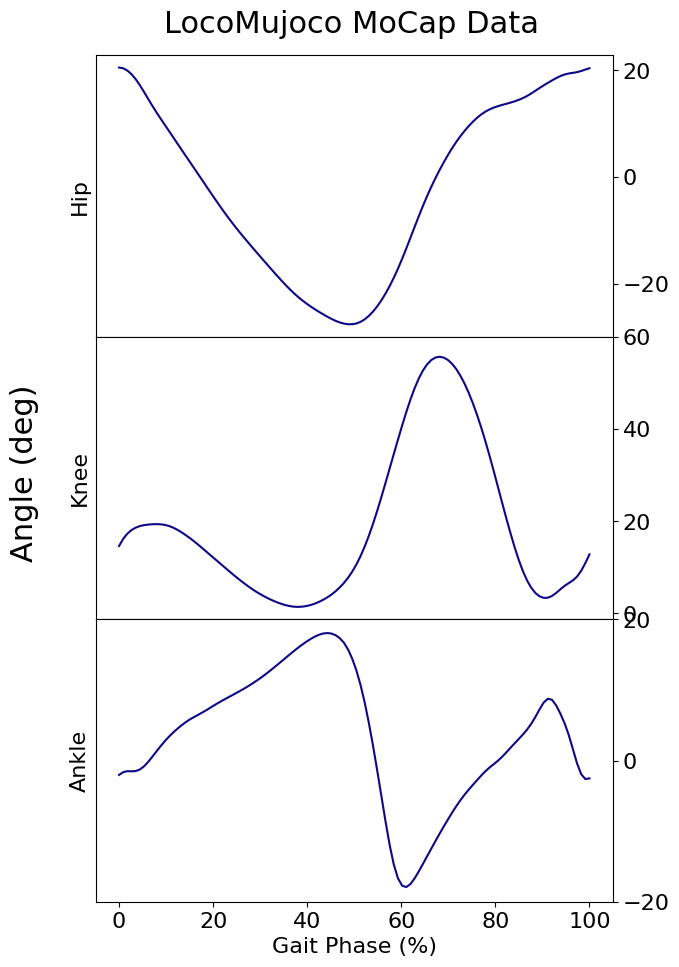

In [24]:
plot_data(original_data, 'LocoMujoco MoCap Data', save=True)

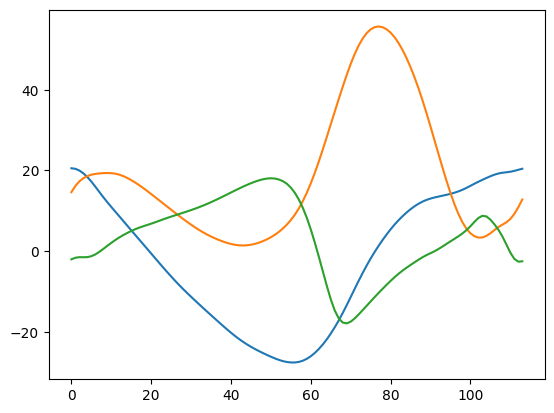

In [24]:

for key in interpolated_cycles:
    avg_cycle = np.mean(interpolated_cycles[key], axis=0)
    plt.plot(avg_cycle)

In [18]:
# with open('linear_models_1101_all_fields_21points.pkl', 'rb') as f:
with open('linear_models_1113_all_fields_21points_rootspeed125.pkl', 'rb') as f:
    linear_models = pickle.load(f)

In [19]:
mean_speed = np.mean(np_obss[:, mdp.get_obs_idx('dq_pelvis_tx')].flatten())
print(f'Mean Speed {mean_speed}')

Mean Speed 1.2814543676916923


In [20]:
lengths = []
for i in range(790):
    lengths.append(len(cycles['q_hip_flexion_r'][i]))
print(f'Mean Length {round(np.mean(lengths))}')

Mean Length 114


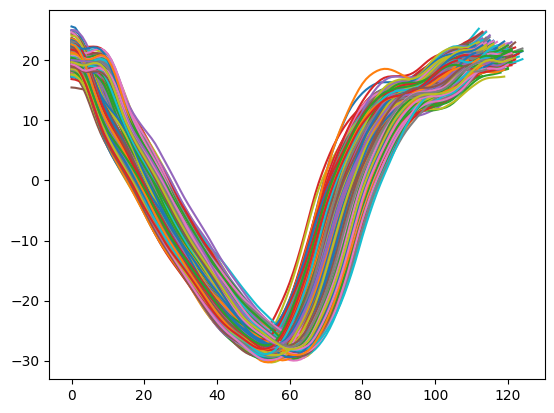

In [21]:
count = 0
for i in range(790):
    if len(cycles['q_hip_flexion_r'][i]) > 90:
        count += len(cycles['q_hip_flexion_r'][i])
        plt.plot(cycles['q_hip_flexion_r'][i])
# plt.savefig('locomujoco seg hip flexion.png')

In [22]:
def interpolate_data(data, mean_length):
    interpolated_data = dict()
    
    for speed in tqdm(data, desc='Interpolating Data'):        
        interpolated_cycles = {}
            
        for joint in data[speed]:
            interpolated_cycles[joint] = []

            for joint_cycle in data[speed][joint]:
                x = np.linspace(0, len(joint_cycle)-1, num=len(joint_cycle))
                xnew = np.linspace(0, len(joint_cycle)-1, num=mean_length)
                spl = CubicSpline(x, joint_cycle) 
                interpolated_cycles[joint].append(spl(xnew))
                    
        for joint in interpolated_cycles:
            interpolated_cycles[joint] = np.array(interpolated_cycles[joint])
    
        interpolated_data[speed] = {
            'cycles': interpolated_cycles,
            'mean_length': mean_length,
        }
        
    return interpolated_data

In [23]:
def plot_data(data, title, save=False, close=False, scatter=False, folder=None):
    mpl.rcParams.update({'font.size': 16})
    
    speeds = list(data.keys())
    idxs_list = []
    joints = ['Hip', 'Knee', 'Ankle']
    joint_names = ['q_hip_flexion_r', 'q_knee_angle_r', 'q_ankle_angle_r']
    for speed in speeds:
        idx = np.linspace(0, 1, data[speed]['mean_length']) * 100
        idxs_list.append(idx)
        
    cmap = plt.get_cmap('plasma')
    norm = plt.Normalize(min(speeds), max(speeds))
    
    fig, axs = plt.subplots(3, 1, figsize=(9, 11))
    
    for i, (joint, joint_names) in enumerate(zip(joints, joint_names)):
        for j, speed in enumerate(speeds):
            avg_cycle = np.mean(data[speed]['cycles'][joint_names], axis=0)
            axs[i].plot(idxs_list[j], avg_cycle, color=cmap(norm(speed)))
            
            # control_gait_phase = get_control_points(avg_cycle, normalize=True)
            # control_angle = np.interp(control_gait_phase, idxs_list[j], avg_cycle)

            if scatter:
                axs[i].scatter(control_gait_phase, control_angle, color='black', s=5, zorder=3)
            axs[i].set_xlim(-5, 105)
    
            if i == 2:
                axs[i].set_xticks([0, 20, 40, 60, 80, 100])
                axs[i].set_xlabel("Gait Phase (%)")
            else:
                axs[i].tick_params('x', labelbottom=False)

        if joint == 'Hip':
            axs[i].set_yticks([-20, 0, 20])
        if joint == 'Knee':
            axs[i].set_yticks([0, 20, 40, 60])
        if joint == 'Ankle':
            axs[i].set_yticks([-20, 0, 20])

        axs[i].yaxis.tick_right()
        axs[i].set_ylabel(joint)
                
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=0)
    fig.subplots_adjust(right=0.7)
    
    # cbar_ax = fig.add_axes([0.8, 0.15, 0.05, 0.7])
    # cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cbar_ax, orientation='vertical')
    # cbar.set_ticks([min(speeds), max(speeds)])
    
    fig.text(0.03, 0.5, 'Angle (deg)', va='center', rotation='vertical', fontdict={'size':22})
    fig.text(0.41, 0.9, f'{title}', horizontalalignment='center', fontdict={'size':22})
    # fig.text(0.89, 0.5, 'Speed (m/s)', va='center', rotation='vertical', fontdict={'size':22})

    if save:
        if folder:
            import os
            os.makedirs(folder, exist_ok=True) 
            plt.savefig(f'{folder}/{title}.png')
        else:
            plt.savefig(f'{title}.png')
    if close:
        plt.close()

In [25]:
def linear_transformation(control_gait_phase, control_angle, linear_models, joint, speed, root_speed):
    assert len(control_gait_phase) == linear_models[joint]['num_control_point']
    gait_phase_intercepts = np.array(linear_models[joint]['intercepts']['Gait Phase'])
    gait_phase_slopes = np.array(linear_models[joint]['slopes']['Gait Phase'])
    angle_intercepts = np.array(linear_models[joint]['intercepts']['Angle'])
    angle_slopes = np.array(linear_models[joint]['slopes']['Angle'])
    transformed_gait_phase = np.add(control_gait_phase, np.add(gait_phase_slopes * (speed - root_speed), gait_phase_intercepts))
    transformed_angle = np.add(control_angle, np.add(angle_slopes * (speed - root_speed), angle_intercepts))
    return transformed_gait_phase, transformed_angle

def unity_transformation(control_xs, control_ys):
    return copy.copy(control_xs), copy.copy(control_ys)

In [26]:
def get_control_points(cycle, normalize=False):
    cycle_length = len(cycle)
    points = [round(cycle_length * 0.05 * x) for x in range(20)]
    points.append(cycle_length -1)
    if normalize:
        points = [point*100/cycle_length for point in points]
    return points

In [29]:
1.35/0.25

5.4

In [30]:
speeds = np.round(np.linspace(0.5, 1.85, 55), 3)

In [31]:
speeds

array([0.5  , 0.525, 0.55 , 0.575, 0.6  , 0.625, 0.65 , 0.675, 0.7  ,
       0.725, 0.75 , 0.775, 0.8  , 0.825, 0.85 , 0.875, 0.9  , 0.925,
       0.95 , 0.975, 1.   , 1.025, 1.05 , 1.075, 1.1  , 1.125, 1.15 ,
       1.175, 1.2  , 1.225, 1.25 , 1.275, 1.3  , 1.325, 1.35 , 1.375,
       1.4  , 1.425, 1.45 , 1.475, 1.5  , 1.525, 1.55 , 1.575, 1.6  ,
       1.625, 1.65 , 1.675, 1.7  , 1.725, 1.75 , 1.775, 1.8  , 1.825,
       1.85 ])

In [32]:
root_speed = 1.25
transformed_data = dict()
for speed in tqdm(speeds, desc='Transforming Data'):
    transformed_data[speed] = {}
    for joint in cycles:
        transformed_data[speed][joint] = []
        for cycle in cycles[joint]:
            cycle_length = len(cycle)
            idx = np.arange(cycle_length)
            if 'knee' in joint:
                cycle = -1*cycle

            if joint == 'q_pelvis_tx':
                new_cycle = cycle * speed / root_speed
                transformed_data[speed][joint].append(new_cycle)
                continue
                
            control_gait_phase = get_control_points(cycle)
            control_angle = np.interp(control_gait_phase, idx, cycle)
            
            # apply transformation
            transformed_gait_phase, transformed_angle = linear_transformation(control_gait_phase, control_angle, linear_models, joint[2:], speed, root_speed)
            Pchip = PchipInterpolator(transformed_gait_phase, transformed_angle, extrapolate='period')
            
            new_cycle = Pchip(idx)
            transformed_data[speed][joint].append(new_cycle)

Transforming Data: 100%|███████████| 55/55 [01:00<00:00,  1.10s/it]


In [33]:
fake_data = interpolate_data(transformed_data, 114)

Interpolating Data: 100%|██████████| 55/55 [00:51<00:00,  1.08it/s]


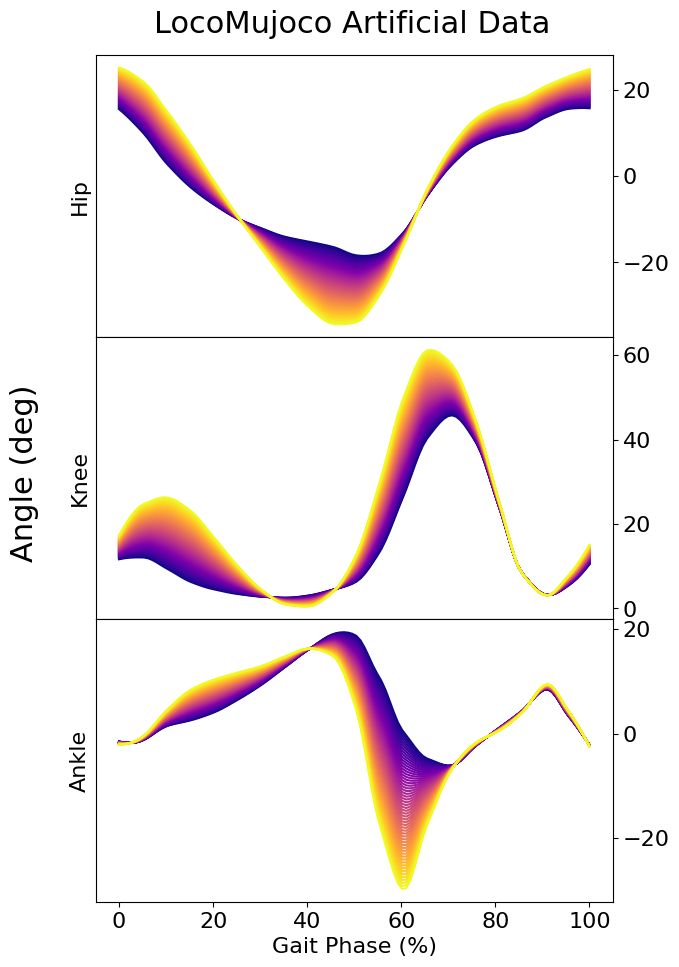

In [34]:
plot_data(fake_data, f'LocoMujoco Artificial Data', save=False, scatter=False, close=False)

In [35]:
with open('locomujoco_transformed_data_55_speeds_0025_increment.pkl', 'wb') as f:
    pickle.dump(transformed_data, f)

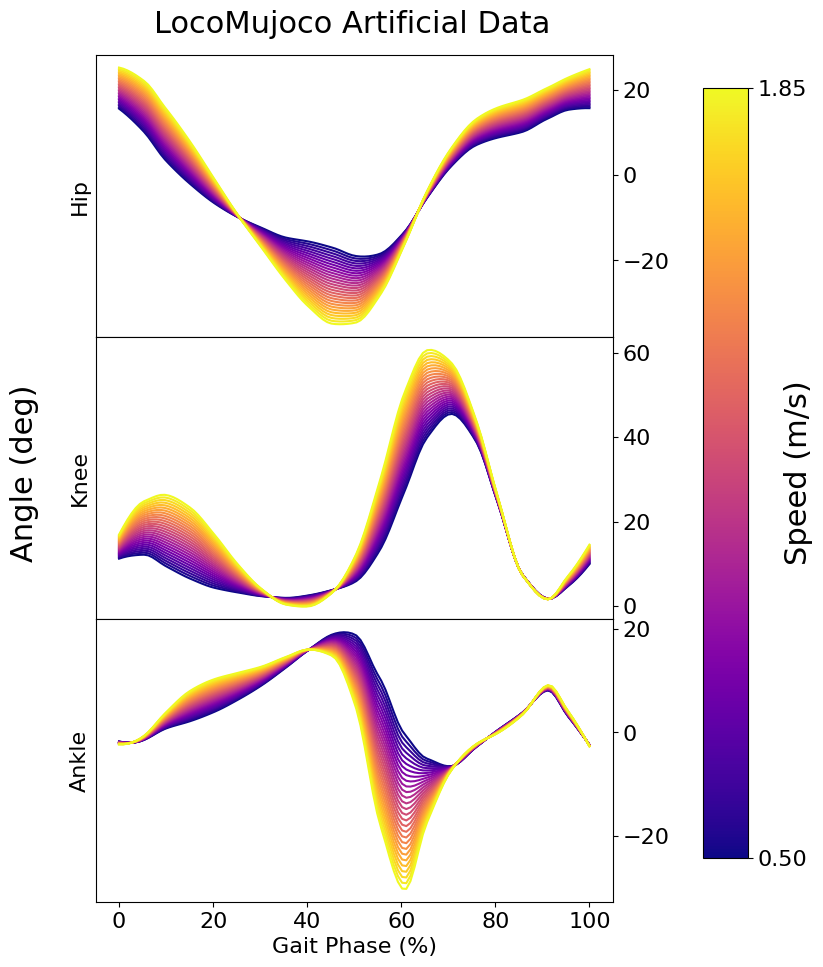

In [32]:
plot_data(fake_data, f'LocoMujoco Artificial Data', save=False, scatter=False, close=False)

In [33]:
with open('locomujoco_transformed_data.pkl', 'wb') as f:
    pickle.dump(transformed_data, f)

In [69]:
len(transformed_data[0.5]['q_pelvis_tx'])

790